In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv("../heart.csv")
print("Dataset shape:", df.shape)
print("\nColumnas:", list(df.columns))
print("\nTipos de datos:")
for col in df.columns:
    print(f"{col}: {df[col].dtype}")
print("\n1ras 5 filas:")
df.head()

Dataset shape: (918, 12)

Columnas: ['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope', 'HeartDisease']

Tipos de datos:
Age: int64
Sex: object
ChestPainType: object
RestingBP: int64
Cholesterol: int64
FastingBS: int64
RestingECG: object
MaxHR: int64
ExerciseAngina: object
Oldpeak: float64
ST_Slope: object
HeartDisease: int64

1ras 5 filas:


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [4]:
# Ver valores nulos
print("Valores nulos por columna:")
print(df.isnull().sum())

# Ver distribución de la variable objetivo
print(f"\nDistribución de HeartDisease:")
print(df['HeartDisease'].value_counts())

# Estadísticas descriptivas
print("\nEstadísticas descriptivas:")
df.describe()

Valores nulos por columna:
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

Distribución de HeartDisease:
HeartDisease
1    508
0    410
Name: count, dtype: int64

Estadísticas descriptivas:


,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [5]:
# Preparar X e y
X = df.drop("HeartDisease", axis=1)
y = df["HeartDisease"]

# Convertir columnas categóricas a numéricas
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
print(f"Columnas categóricas encontradas: {categorical_cols}")

if categorical_cols:
    for col in categorical_cols:
        print(f"Convirtiendo {col}: {X[col].unique()} -> códigos numéricos")
        X[col] = pd.factorize(X[col])[0]
else:
    print("No hay columnas categóricas - todo es numérico")

print("\nDatos preparados")
print(f"X shape: {X.shape}")
print(f"Tipos de datos finales: {X.dtypes.unique()}")

Columnas categóricas encontradas: ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
Convirtiendo Sex: ['M' 'F'] -> códigos numéricos
Convirtiendo ChestPainType: ['ATA' 'NAP' 'ASY' 'TA'] -> códigos numéricos
Convirtiendo RestingECG: ['Normal' 'ST' 'LVH'] -> códigos numéricos
Convirtiendo ExerciseAngina: ['N' 'Y'] -> códigos numéricos
Convirtiendo ST_Slope: ['Up' 'Flat' 'Down'] -> códigos numéricos

Datos preparados
X shape: (918, 11)
Tipos de datos finales: [dtype('int64') dtype('float64')]


In [6]:
np.random.seed(0)
X_leaky = X.copy()
X_leaky["leaky_feature"] = y + np.random.normal(0, 0.01, size=len(y))
print("Variable 'leaky_feature' creada")
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_leaky)
# divición de datos
X_train_leaky, X_test_leaky, y_train_leaky, y_test_leaky = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)
# entrenamienti con fuga
grid_leaky = GridSearchCV(
    SVC(probability=True), 
    param_grid={"C": [0.1, 1, 10], "gamma": [0.01, 0.1]}, 
    cv=5, 
    scoring="roc_auc"
)
grid_leaky.fit(X_train_leaky, y_train_leaky)
auc_leaky = roc_auc_score(y_test_leaky, grid_leaky.predict_proba(X_test_leaky)[:, 1])
print(f"AUC con data leakage: {auc_leaky:.3f}")

Variable 'leaky_feature' creada
AUC con data leakage: 1.000


In [7]:
# Flujo sin fuga
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
# Pipeline correcto 
pipe = Pipeline([
    ("scaler", MinMaxScaler()), 
    ("svc", SVC(probability=True))
])
param_grid = {
    "svc__C": [0.1, 1, 10], 
    "svc__gamma": [0.01, 0.1]
}
grid_correct = GridSearchCV(
    pipe, 
    param_grid, 
    cv=5, 
    scoring="roc_auc"
)
grid_correct.fit(X_train, y_train)
auc_correct = roc_auc_score(y_test, grid_correct.predict_proba(X_test)[:, 1])
print(f"AUC sin data leakage: {auc_correct:.3f}")

AUC sin data leakage: 0.894


In [8]:
print("COMPARACIÓN DE RESULTADOS:")
print(f"AUC con data leakage:    {auc_leaky:.3f}")
print(f"AUC sin data leakage:    {auc_correct:.3f}")
print(f"Diferencia:              {auc_leaky - auc_correct:.3f}")
if auc_leaky > auc_correct:
    print("\nEl data leakage infla artificialmente el rendimiento")
else:
    print("\nEl flujo correcto evita el sobreajuste")

COMPARACIÓN DE RESULTADOS:
AUC con data leakage:    1.000
AUC sin data leakage:    0.894
Diferencia:              0.106

El data leakage infla artificialmente el rendimiento


c:\Users\Administrador\miniconda3\envs\ml_venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Administrador\miniconda3\envs\ml_venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Administrador\miniconda3\envs\ml_venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


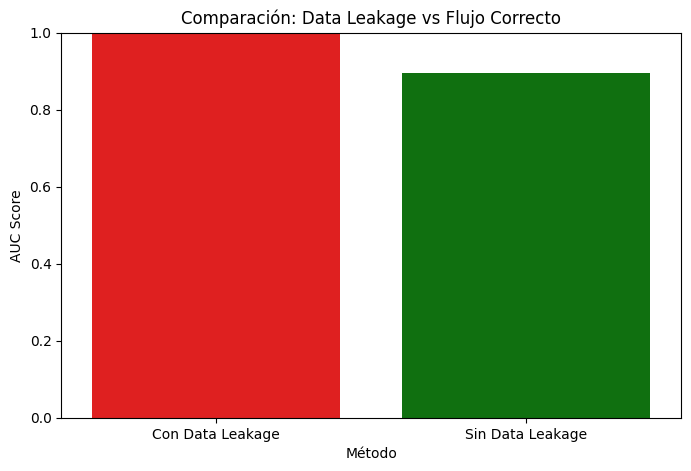

In [9]:
# Gráfico de comparación
results = pd.DataFrame({
    'Método': ['Con Data Leakage', 'Sin Data Leakage'],
    'AUC': [auc_leaky, auc_correct]
})

plt.figure(figsize=(8, 5))
sns.barplot(x='Método', y='AUC', data=results, palette=['red', 'green'])
plt.title('Comparación: Data Leakage vs Flujo Correcto')
plt.ylim(0, 1)
plt.ylabel('AUC Score')
plt.show()